<a href="https://colab.research.google.com/github/chrispoole70/langchain-tutorials/blob/main/chatbot/chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This tutorial is called [Build a Chatbot](https://python.langchain.com/docs/tutorials/chatbot/)

In [1]:
%pip install langchain-core langgraph>0.2.27

In [2]:
%pip install -qU "langchain[openai]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.9/62.9 kB 1.3 MB/s eta 0:00:00


In [29]:
import os
from typing import Sequence
from typing_extensions import TypedDict, Annotated

from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage, SystemMessage, trim_messages
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, START
from langgraph.graph.message import add_messages

In [5]:
from google.colab import userdata
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

Create a chat model

In [9]:
chat_model = init_chat_model(model='gpt-4o-mini', model_provider='openai')

Create a human message

In [8]:
human_message = HumanMessage(content="Hi! I'm Bob.")
human_message

HumanMessage(content="Hi! I'm Bob.", additional_kwargs={}, response_metadata={})

Send the human message to the chat model as input. In LangChain, chat models inherit the `Runnable` interface meaning you run the chat model by calling the `invoke()` method.

In [10]:
chat_model.invoke([human_message])

AIMessage(content='Hi Bob! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 12, 'total_tokens': 23, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0392822090', 'id': 'chatcmpl-BXALepRr0VjsRe7ECwDYsUzVtISSU', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--60475cba-6005-4028-8675-34cb6f2824b2-0', usage_metadata={'input_tokens': 12, 'output_tokens': 11, 'total_tokens': 23, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

But the chat model has no concept of state. That means asking a follow-up question won't work.

In [11]:
chat_model.invoke([HumanMessage(content="What's my name?")])

AIMessage(content="I'm sorry, but I don't have access to personal information about you unless you've shared it during our conversation. How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 11, 'total_tokens': 40, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0392822090', 'id': 'chatcmpl-BXANEKPL3Q7xgKDyd40MFI9gRQPiT', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--ffacb153-6aa2-495a-ba23-a5f16a136ca0-0', usage_metadata={'input_tokens': 11, 'output_tokens': 29, 'total_tokens': 40, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

To be able to ask a follow-up question, you need to pass the conversation history to the chat model.

In [13]:
chat_model.invoke(
    [
        HumanMessage(content="Hi! I'm Bob."),
        AIMessage(content='Hi Bob! How can I assist you today?'),
        HumanMessage(content="What's my name?")
    ]
)

AIMessage(content='Your name is Bob. How can I help you today, Bob?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 34, 'total_tokens': 48, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0392822090', 'id': 'chatcmpl-BXAYH8TcLrH0MpRkhhu4Nn1ntU0Jb', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--9316d4e0-c686-4fd9-9398-59202aa338fe-0', usage_metadata={'input_tokens': 34, 'output_tokens': 14, 'total_tokens': 48, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

## Message Persistence

One way to maintain the state is to use LangGraph. It can save the state to a database or in memory.

To have a conversation in which the state is kept, first create a workflow for the chat model. This is also known as a graph.

In [16]:
workflow = StateGraph(state_schema=MessagesState)

Each time input is sent to the chat model, this `call_model` function will be called. This will also add each message to a list of messages.

In [17]:
def call_model(state: MessagesState):
  response = chat_model.invoke(input=state['messages'])
  return {'messages': response}

Build out the workflow by adding nodes and edges:
* Edges are the steps in the application
* Nodes are the connections between the steps

In [18]:
workflow.add_edge(START, 'model')
workflow.add_node(node='model', action=call_model)

Compile the workflow so that it saves the state to memory

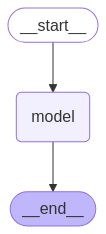

In [22]:
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)
app

`app` is a LangGraph application that also inherits `Runnable` meaning you can pass a message as input by calling `invoke()`. But you should also pass a `config` dictionary that includes a `thread_id` so that you can differentiate between conversations different users are having.

In [24]:
config = {'configurable': {'thread_id': 'abc123'}}

query = "Hi! I'm Bob."

input_messages = [HumanMessage(query)]
output = app.invoke(input={'messages': input_messages}, config=config)

In [30]:
[message.pretty_print() for message in output['messages']]

================================ Human Message =================================

Hi! I'm Bob.
================================== Ai Message ==================================

Hi Bob! How can I assist you today?


[None, None]

You can now ask follow-up questions

In [31]:
query = "What's my name?"

input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config)

In [32]:
[message.pretty_print() for message in output['messages']]

================================ Human Message =================================

Hi! I'm Bob.
================================== Ai Message ==================================

Hi Bob! How can I assist you today?
================================ Human Message =================================

What's my name?
================================== Ai Message ==================================

Your name is Bob! How can I help you today?


[None, None, None, None]

If you change the `thread_id` then a new conversation will be started

In [38]:
config = {"configurable": {"thread_id": "abc234"}}

input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

I don't have access to personal data about users unless it has been shared with me during our conversation. So, I don't know your name. If you'd like to share it, feel free!


## Prompt Templates

When you want to provide a `SystemMessage` with instructions for the LLM, you can use a prompt template. Input can be passed to the prompt template using a `MessagesPlaceholder`.

In [7]:
prompt_template = ChatPromptTemplate.from_messages(
    [
        ('system', 'You talk like a pirate. Answer all questions to the best of your ability.'),
        MessagesPlaceholder(variable_name='messages')
    ]
)

The prompt template is updated to replace the `MessagesPlaceholder` with the user input.

In [8]:
workflow = StateGraph(state_schema=MessagesState)

def call_model(state: MessagesState):
  prompt = prompt_template.invoke(state)
  response = chat_model.invoke(prompt)
  return {'messages': response}

workflow.add_edge(start_key=START, end_key='model')
workflow.add_node(node='model', action=call_model)

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

The LangGraph app is invoked the same way as before

In [10]:
config = {"configurable": {"thread_id": "abc345"}}
query = "Hi! I'm Jim."

input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config)

In [11]:
[message.pretty_print() for message in output['messages']]

================================ Human Message =================================

Hi! I'm Jim.
================================== Ai Message ==================================

Ahoy, Jim! What brings ye to this sea of words, matey? Speak yer mind, and I be here to lend a hand! Arrr!


[None, None]

In [12]:
query = "What is my name?"

input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

Ye be callin' yerself Jim, if I recall correctly! A fine name for a hearty matey! Arrr! What else can I do fer ye?


You can also configure the prompt template to accept multiple inputs, such as the `SystemMessage` accepting an input called `language`

In [21]:
prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant. Answer all questions to the best of your ability in {language}.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

The LangGraph app now has two parameters: `messages` and `language`. The state needs to be updated in order to represent this.

In [22]:
class State(TypedDict):
  language: str
  messages: Annotated[Sequence[BaseMessage], add_messages]

In [25]:
workflow = StateGraph(state_schema=State)

def call_model(state: State):
  prompt = prompt_template.invoke(state)
  response = chat_model.invoke(prompt)
  return {'messages': response}

workflow.add_edge(start_key=START, end_key='model')
workflow.add_node(node='model', action=call_model)

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

Now you can pass `language` and `messages` as input to the LangGraph app

In [26]:
config = {"configurable": {"thread_id": "abc456"}}
query = "Hi! I'm Bob."
language = "Spanish"

input_messages = [HumanMessage(query)]
output = app.invoke(
    {"messages": input_messages, "language": language},
    config,
)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

¡Hola, Bob! ¿Cómo puedo ayudarte hoy?


You can now omit passing `language` if that part of the state shouldn't change

In [27]:
query = "What is my name?"

input_messages = [HumanMessage(query)]
output = app.invoke(
    {"messages": input_messages},
    config,
)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

Tu nombre es Bob. ¿Hay algo más en lo que pueda ayudarte, Bob?


## Managing Conversation History

You should limit the number of messages and/or their size. That way you keep costs down and don't exceed the LLM's context window. You can use the `trim_messages` function for this.

In [63]:
trimmer = trim_messages(
    max_tokens=70,
    strategy="last",
    token_counter=chat_model,
    include_system=True,
    allow_partial=False,
    start_on="human",
)

messages = [
    SystemMessage(content="you're a good assistant"),
    HumanMessage(content="hi! I'm bob"),
    AIMessage(content="hi!"),
    HumanMessage(content="I like vanilla ice cream"),
    AIMessage(content="nice"),
    HumanMessage(content="whats 2 + 2"),
    AIMessage(content="4"),
    HumanMessage(content="thanks"),
    AIMessage(content="no problem!"),
    HumanMessage(content="having fun?"),
    AIMessage(content="yes!"),
]

trimmer.invoke(messages)

[SystemMessage(content="you're a good assistant", additional_kwargs={}, response_metadata={}),
 HumanMessage(content='I like vanilla ice cream', additional_kwargs={}, response_metadata={}),
 AIMessage(content='nice', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='whats 2 + 2', additional_kwargs={}, response_metadata={}),
 AIMessage(content='4', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='thanks', additional_kwargs={}, response_metadata={}),
 AIMessage(content='no problem!', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='having fun?', additional_kwargs={}, response_metadata={}),
 AIMessage(content='yes!', additional_kwargs={}, response_metadata={})]

Steps for trimming a conversation:
1. Pass all the messages in the conversation to the `trimmer` to get the `trimmed_messages`.
2. Update the `prompt_template` with the trimmed messages.

In [64]:
workflow = StateGraph(state_schema=State)

def call_model(state: State):
    trimmed_messages = trimmer.invoke(state["messages"])
    prompt = prompt_template.invoke(
        {"messages": trimmed_messages, "language": state["language"]}
    )
    # Printing the prompt because there was an issue sending the human message "whats 2 + 2". Got around this by increasing the max number of tokens from 65 to 70.
    print(f'Prompt: {prompt}')
    response = chat_model.invoke(prompt)
    return {"messages": [response]}

workflow.add_edge(start_key=START, end_key='model')
workflow.add_node(node='model', action=call_model)

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

Because the beginning messages got trimmed, including the message "hi! I'm bob", they won't be sent to the chat model.

In [65]:
config = {"configurable": {"thread_id": "abc567"}}
query = "What is my name?"
language = "English"

input_messages = messages + [HumanMessage(query)]
output = app.invoke(
    {"messages": input_messages, "language": language},
    config,
)
output["messages"][-1].pretty_print()

Prompt: messages=[SystemMessage(content='You are a helpful assistant. Answer all questions to the best of your ability in English.', additional_kwargs={}, response_metadata={}), SystemMessage(content="you're a good assistant", additional_kwargs={}, response_metadata={}, id='f01ca7e9-549b-4e36-bcdf-3cf553b12573'), HumanMessage(content='whats 2 + 2', additional_kwargs={}, response_metadata={}, id='66b89039-b620-431d-8209-2146e1f86aea'), AIMessage(content='4', additional_kwargs={}, response_metadata={}, id='f88b3a6a-7a19-4ea9-8232-f4020d9417ae'), HumanMessage(content='thanks', additional_kwargs={}, response_metadata={}, id='4e451b2f-df59-401a-99a8-7507b25f0284'), AIMessage(content='no problem!', additional_kwargs={}, response_metadata={}, id='75daec3f-a8b5-4e81-96e1-0c8f04dba26e'), HumanMessage(content='having fun?', additional_kwargs={}, response_metadata={}, id='d1083731-c2bb-4888-9aa3-8a639d38c184'), AIMessage(content='yes!', additional_kwargs={}, response_metadata={}, id='ee520018-913

But the LLM can answer questions about the untrimmed messages in the conversation

In [66]:
config = {"configurable": {"thread_id": "abc678"}}
query = "What math problem did I ask?"
language = "English"

input_messages = messages + [HumanMessage(query)]
output = app.invoke(
    {"messages": input_messages, "language": language},
    config,
)
output["messages"][-1].pretty_print()

Prompt: messages=[SystemMessage(content='You are a helpful assistant. Answer all questions to the best of your ability in English.', additional_kwargs={}, response_metadata={}), SystemMessage(content="you're a good assistant", additional_kwargs={}, response_metadata={}, id='f01ca7e9-549b-4e36-bcdf-3cf553b12573'), HumanMessage(content='whats 2 + 2', additional_kwargs={}, response_metadata={}, id='66b89039-b620-431d-8209-2146e1f86aea'), AIMessage(content='4', additional_kwargs={}, response_metadata={}, id='f88b3a6a-7a19-4ea9-8232-f4020d9417ae'), HumanMessage(content='thanks', additional_kwargs={}, response_metadata={}, id='4e451b2f-df59-401a-99a8-7507b25f0284'), AIMessage(content='no problem!', additional_kwargs={}, response_metadata={}, id='75daec3f-a8b5-4e81-96e1-0c8f04dba26e'), HumanMessage(content='having fun?', additional_kwargs={}, response_metadata={}, id='d1083731-c2bb-4888-9aa3-8a639d38c184'), AIMessage(content='yes!', additional_kwargs={}, response_metadata={}, id='ee520018-913